# Hierarchy clustering utils
Agglomerative clustering is very flexible in terms of the clustering granularity. By default it constructs the entire dendrogram and you can choose any number of clusters in [1, num_samples]. Sometimes it could be interesting given the clustering result to explore children, parents or sibling of a particular cluster.

**Sometimes we want to check whether it make sence to merge a particular cluster with it's sibling in dendrogram or to split a particular cluster into it's children.** It makes sence when some meaningfull entities are clustered (e.g. words, movies, music tracks - entities for which we as humans can assess similarity). Given we can assess entities similarity, we can decide to merge or split a cluster.

By default neither in scipy.cluster.hierarchy nor sklearn.cluster.AgglomerativeClustering have a convenient way to get cluster's children, parents or siblings. In this repo I implemented functions to do this and provided a small demo.

##  Cluster merging
As mentioned before we need to be able to assess similarity of clustered entities and decide to merge or split a cluster. Let's consider clusters of 2d points as an example of such entites.

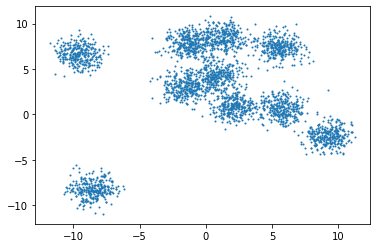

In [1]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as shc
import numpy as np
import pandas as pd
from hierarchy_cluster_utils import (
    get_distances_and_counts,
    get_node,
    get_parent_and_sibling_for_node,
    get_leaves_ids
)
data = make_blobs(centers=10, cluster_std=0.9, n_samples=3000, random_state=0)
plt.scatter(data[0][:,0],data[0][:,1],s=1)
dots_df = pd.DataFrame(columns=['cluster_id', 'coords', 'intracluster_distance', 'intracluster_count'])
dots_df.loc[:, 'coords'] = data[0].tolist()

Let us build the dendrogram (linkage matrix) and split the data into 15 clusters.

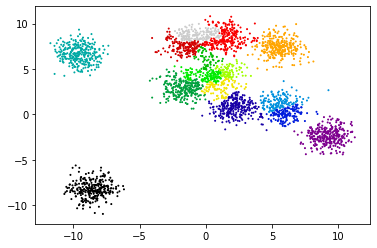

In [2]:
lkage = shc.linkage(data[0], method='ward')
cluster_ids = shc.fcluster(lkage, t=15, criterion='maxclust')
dots_df.loc[:, 'cluster_id'] = cluster_ids
distances, counts = get_distances_and_counts(lkage, dots_df['cluster_id'].values)
dots_df.loc[:, 'intracluster_distance'] = distances
dots_df.loc[:, 'intracluster_count'] = counts
plt.scatter(data[0][:,0], data[0][:,1], s=1, c=dots_df['cluster_id'].values, cmap=plt.cm.nipy_spectral)

Now let's look at the most compact clusters (probably it makes sence to merge them with their siblings).

In [3]:
dots_df[['cluster_id', 'intracluster_distance', 'intracluster_count']] \
.drop_duplicates() \
.sort_values(by='intracluster_distance').head(3)

,cluster_id,intracluster_distance,intracluster_count
2,10,5.504588,84
26,8,6.294652,62
24,11,8.818093,99


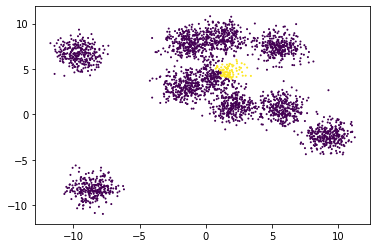

In [4]:
plt.scatter(data[0][:,0], data[0][:,1], s=1, c=dots_df['cluster_id']==10)

Let's look a the sibling of the cluster with id 10. It seems that we can merge them. But probably we can go further and look at the grandparent of the cluster with id 10 (parent of the parent of cluster 10).

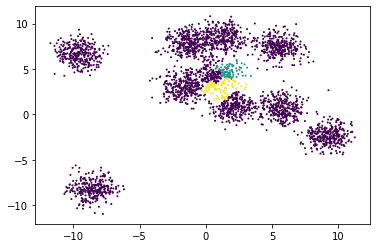

In [5]:
node = get_node(lkage, dots_df['cluster_id'].values, 10)
parent, sibling = get_parent_and_sibling_for_node(lkage, node)
sibling_samples = get_leaves_ids(sibling)
color = np.zeros(shape=dots_df.shape[0])
color[dots_df['cluster_id']==10] = 1
color[sibling_samples] = 2
plt.scatter(data[0][:,0], data[0][:,1], s=1, c=color)

It seems that we can merge all descendants of the grandparent into one cluster.

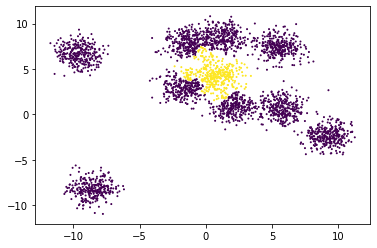

In [6]:
grandparent, _ = get_parent_and_sibling_for_node(lkage, parent)
color = np.zeros(shape=dots_df.shape[0])
color[get_leaves_ids(grandparent)] = 1
plt.scatter(data[0][:,0], data[0][:,1], s=1, c=color)

Let's merge all descendants of the grandparent into one cluster and label this cluster as 10 (as soon cluster 10 according to the initial clustering is part of this new cluster).

Let us do similar thing again several times until we are satisfied with the result.

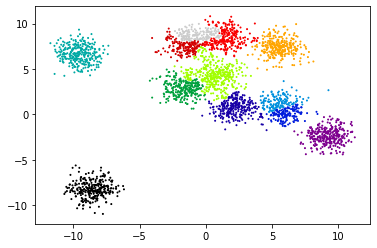

In [7]:
dots_df.loc[get_leaves_ids(grandparent), 'cluster_id'] = 10
plt.scatter(data[0][:,0], data[0][:,1], s=1, c=dots_df['cluster_id'].values, cmap=plt.cm.nipy_spectral)

In [8]:
distances, counts = get_distances_and_counts(lkage, dots_df['cluster_id'].values)
dots_df.loc[:, 'intracluster_distance'] = distances
dots_df.loc[:, 'intracluster_count'] = counts
dots_df[['cluster_id', 'intracluster_distance', 'intracluster_count']] \
.drop_duplicates() \
.sort_values(by='intracluster_distance').head(3)

,cluster_id,intracluster_distance,intracluster_count
12,4,9.978289,145
81,5,11.132667,144
136,14,12.026664,169


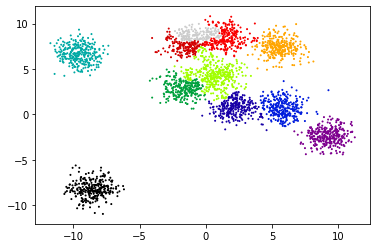

In [9]:
node = get_node(lkage, dots_df['cluster_id'].values, 4)
parent, _ = get_parent_and_sibling_for_node(lkage, node)
parent_samples = get_leaves_ids(parent)
dots_df.loc[parent_samples, 'cluster_id'] = 4
plt.scatter(data[0][:,0], data[0][:,1], s=1, c=dots_df['cluster_id'].values, cmap=plt.cm.nipy_spectral)

In [10]:
distances, counts = get_distances_and_counts(lkage, dots_df['cluster_id'].values)
dots_df.loc[:, 'intracluster_distance'] = distances
dots_df.loc[:, 'intracluster_count'] = counts
dots_df[['cluster_id', 'intracluster_distance', 'intracluster_count']] \
.drop_duplicates() \
.sort_values(by='intracluster_distance').head(3)

,cluster_id,intracluster_distance,intracluster_count
136,14,12.026664,169
8,15,12.759969,152
5,7,15.839499,260


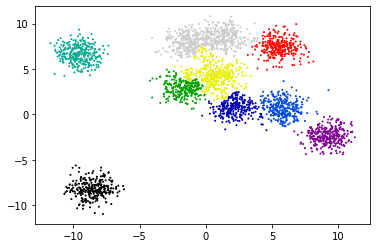

In [11]:
# here we merge descendants of grandparent of cluster 14 into one cluster
node = get_node(lkage, dots_df['cluster_id'].values, 14)
parent, _ = get_parent_and_sibling_for_node(lkage, node)
parent_samples = get_leaves_ids(parent)
dots_df.loc[parent_samples, 'cluster_id'] = 14
node = get_node(lkage, dots_df['cluster_id'].values, 14)
parent, _ = get_parent_and_sibling_for_node(lkage, node)
parent_samples = get_leaves_ids(parent)
dots_df.loc[parent_samples, 'cluster_id'] = 14
plt.scatter(data[0][:,0], data[0][:,1], s=1, c=dots_df['cluster_id'].values, cmap=plt.cm.nipy_spectral)

## Cluster splitting
Now let's use the linkage matrix to split the data into 5 clusters.

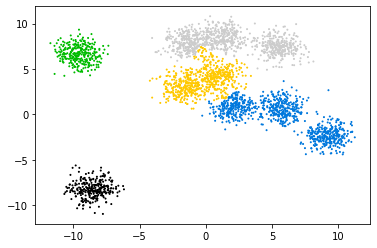

In [12]:
cluster_ids = shc.fcluster(lkage, t=5, criterion='maxclust')
dots_df.loc[:, 'cluster_id'] = cluster_ids
distances, counts = get_distances_and_counts(lkage, dots_df['cluster_id'].values)
dots_df.loc[:, 'intracluster_distance'] = distances
dots_df.loc[:, 'intracluster_count'] = counts
plt.scatter(data[0][:,0], data[0][:,1], s=1, c=dots_df['cluster_id'].values, cmap=plt.cm.nipy_spectral)

Here are the clusters with the highest intra-cluster distances.

In [13]:
dots_df[['cluster_id', 'intracluster_distance', 'intracluster_count']] \
.drop_duplicates() \
.sort_values(by='intracluster_distance', ascending=False).head(3)

,cluster_id,intracluster_distance,intracluster_count
0,2,120.164959,879
1,5,109.880057,871
2,4,49.365142,650


Let us check whether it makes sence to split cluster with id 2 into it's children.

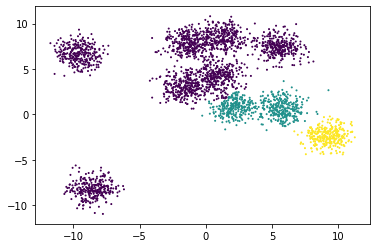

In [14]:
node = get_node(lkage, dots_df['cluster_id'].values, 2)
right = node.get_right()
left = node.get_left()
right_samples = get_leaves_ids(right)
left_samples = get_leaves_ids(left)
color = np.zeros(shape=dots_df.shape[0])
color[right_samples] = 1
color[left_samples] = 2
plt.scatter(data[0][:,0], data[0][:,1], s=1, c=color)

Seems that the split makes sence. Splitting

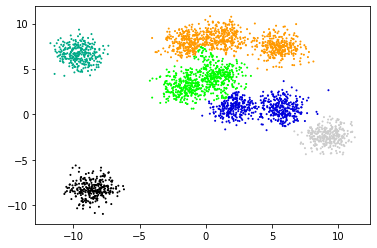

In [15]:
dots_df.loc[right_samples, 'cluster_id'] = 2
dots_df.loc[left_samples, 'cluster_id'] = 6  # dots_df['cluster_id'].max() + 1
plt.scatter(data[0][:,0], data[0][:,1], s=1, c=dots_df['cluster_id'].values, cmap=plt.cm.nipy_spectral)

Let's do the same thing again several times.

In [16]:
distances, counts = get_distances_and_counts(lkage, dots_df['cluster_id'].values)
dots_df.loc[:, 'intracluster_distance'] = distances
dots_df.loc[:, 'intracluster_count'] = counts
dots_df[['cluster_id', 'intracluster_distance', 'intracluster_count']] \
.drop_duplicates() \
.sort_values(by='intracluster_distance', ascending=False).head(3)

,cluster_id,intracluster_distance,intracluster_count
1,5,109.880057,871
0,2,60.575160,577
2,4,49.365142,650


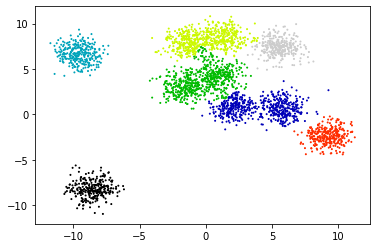

In [17]:
node = get_node(lkage, dots_df['cluster_id'].values, 5)
right = node.get_right()
left = node.get_left()
right_samples = get_leaves_ids(right)
left_samples = get_leaves_ids(left)
dots_df.loc[right_samples, 'cluster_id'] = 5
dots_df.loc[left_samples, 'cluster_id'] = 7  # dots_df['cluster_id'].max() + 1
plt.scatter(data[0][:,0], data[0][:,1], s=1, c=dots_df['cluster_id'].values, cmap=plt.cm.nipy_spectral)

In [18]:
distances, counts = get_distances_and_counts(lkage, dots_df['cluster_id'].values)
dots_df.loc[:, 'intracluster_distance'] = distances
dots_df.loc[:, 'intracluster_count'] = counts
dots_df[['cluster_id', 'intracluster_distance', 'intracluster_count']] \
.drop_duplicates() \
.sort_values(by='intracluster_distance', ascending=False).head(3)

,cluster_id,intracluster_distance,intracluster_count
0,2,60.575160,577
2,4,49.365142,650
6,5,46.825874,576


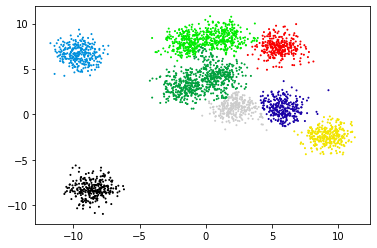

In [19]:
node = get_node(lkage, dots_df['cluster_id'].values, 2)
right = node.get_right()
left = node.get_left()
right_samples = get_leaves_ids(right)
left_samples = get_leaves_ids(left)
dots_df.loc[right_samples, 'cluster_id'] = 2
dots_df.loc[left_samples, 'cluster_id'] = 8  # dots_df['cluster_id'].max() + 1
plt.scatter(data[0][:,0], data[0][:,1], s=1, c=dots_df['cluster_id'].values, cmap=plt.cm.nipy_spectral)